In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

from scipy.ndimage import label, generate_binary_structure, binary_dilation


# Helper functions......    

def open_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
        
    def add_fhour(ds):
        filename = ds.encoding["source"].split(".nc")
           
        init_time = 0
        fhour     = int(filename[0][-2:])
                
        ds.coords['fhour']     = fhour
        ds.coords['init_time'] = init_time

    filelist = os.path.join(data_dir,pattern)
 #   return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

    return xr.open_mfdataset(filelist,parallel=True)




In [58]:
def get_cm1_profiles(run_dir, w_thresh = 5.0, cref_thresh = 45., min_pix=5):
    
    ds = open_mfdataset_list(run_dir,  "cm1out_0000*.nc")
    
    cref = (ds.dbz.values).max(axis=1)

    mask_cref = np.where(cref >= cref_thresh, True, False)

    mask_p = np.where(ds.prs <= 70000., True, False)

    mask_w = np.where(ds.winterp > w_thresh, True, False)

    mask_w_p = mask_p & mask_w

    mask_w_p_2d = np.any(mask_w_p, axis=1)
    
    f_mask = np.array(np.where(mask_w_p_2d, 1, 0), dtype=np.int8)
    
    winterp = ds.winterp.values

    # this code looks for a 3x3 connected region of True (1) values.
    
    connectivity = np.ones((3,) * 2)  # 3x3 matric of ones

    wlist = [] 
    total_obj = 0
    
    for n in np.arange(ds.winterp.shape[0]): # loop over number of time steps.
        
        labeled_array = label(f_mask[n], connectivity)[0]        # returns a 2D array of labels for updrafts)
    
        num_obj = np.unique(labeled_array)                       # find the number of unique objects (background will be one obj)
        
        total_obj += (num_obj.shape[0]-1)
        
        if( num_obj.shape[0] > 1 ):                              # if there is more than the background object, process array.

            for l in num_obj[1:]:                                # this is just a list of 1,2,3,4.....23,24,25....
                npix = np.sum(labeled_array == l+1)              # this is a size check - number of pixels assocated with a label
                if npix >= min_pix:
                    jloc, iloc = np.where(labeled_array == l+1)  # extract out the locations of the updrafts 
                    if len(iloc) > 0:
                        data = winterp[n,:,jloc,iloc]  # average profiles for that object.
                        wlist.append(data.transpose())                  
    
    wprofile = np.hstack(wlist)

    print("Directory:  %s  Number of updraft profiles:  %d" % (os.path.basename(run_dir), wprofile.shape[1]))
    print("Number of labeled objects:  %d" % total_obj)

    zc = ds.zh.values
    
    ds.close()
    
    return wprofile, zc

In [59]:
def get_fv3_profiles(run_dir, w_thresh = 5.0, cref_thresh = 45., min_pix=5):
    
    def open_mfdataset_list(data_dir, pattern):
        """
        Use xarray.open_mfdataset to read multiple netcdf files from a list.
        """
        filelist = os.path.join(data_dir,pattern)
        return xr.open_mfdataset(filelist, combine='nested', concat_dim=['time'], parallel=True)
    
    ds = open_mfdataset_list(run_dir,   "*.nc")

    cref = (ds.REFL_10CM.values).max(axis=1)

    mask_cref = np.where(cref >= cref_thresh, True, False)

    mask_p = np.where(ds.P <= 70000., True, False)
    
    winterp = ds.W.values
    
    mask_w = np.where(winterp > w_thresh, True, False)

    mask_w_p = mask_p & mask_w

    mask_w_p_2d = np.any(mask_w_p, axis=1)

    f_mask = np.array(np.where(mask_w_p_2d, 1, 0), dtype=np.int8)

    # this code looks for a 3x3 connected region of True (1) values.
    
    connectivity = np.ones((3,) * 2)  # 3x3 matric of ones

    wlist = [] 
    
    for n in np.arange(winterp.shape[0]): # loop over number of time steps.
        
        labeled_array = label(f_mask[n], connectivity)[0]        # returns a 2D array of labels for updrafts)
    
        num_obj = np.unique(labeled_array)                       # find the number of unique objects (background will be one obj)
        
        print(n, num_obj.shape[0])

        if( num_obj.shape[0] > 1 ):                              # if there is more than the background object, process array.

            for l in num_obj[1:]:                                # this is just a list of 1,2,3,4.....23,24,25....
                npix = np.sum(labeled_array == l+1)              # this is a size check - number of pixels assocated with a label
                if npix >= min_pix:
                    jloc, iloc = np.where(labeled_array == l+1)  # extract out the locations of the updrafts 
                    if len(iloc) > 0:
                        data = winterp[n,:,jloc,iloc]  # average profiles for that object.
                        wlist.append(data)
                        
    # wprofile = np.hstack(wlist)
    # print(wprofile.shape)
    
    wprofile = np.asarray(wlist).transpose()

    print("Directory:  %s  Number of updraft points:  %d" % (os.path.basename(run_dir), wprofile.shape[1]))    
# get z's

    ze = ds.PHB.values/9.806
    
    ds.close()
    
    ze = ze.mean(axis=(0,2,3))
    
    zc = 0.5*(ze[1:] + ze[:-1])
    
    return wprofile, ze
    

In [60]:
w_thresh = 5.0
cref_thresh = 35.
min_pix = 3

input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'

# wprofile_q11, zh_q14 = get_cm1_profiles(str(os.path.join(input_dir, 'squall_q11_s12')), w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# wprofile_q12, zh_q14 = get_cm1_profiles(str(os.path.join(input_dir, 'squall_q12_s12')), w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# wprofile_q13, zh_q14 = get_cm1_profiles(str(os.path.join(input_dir, 'squall_q13_s12')), w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
wprofile_q14, zh_q14 = get_cm1_profiles(str(os.path.join(input_dir, 'squall_q14_s12')), w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# wprofile_q15, zh_q14 = get_cm1_profiles(str(os.path.join(input_dir, 'squall_q15_s12')), w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# wprofile_q16, zh_q14 = get_cm1_profiles(str(os.path.join(input_dir, 'squall_q16_s12')), w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)

# in_dir  = "/scratch/larissa.reames/ideal_updrafts"
# out_dir = "/work/wicker/CAM_analysis_tools"
# shear   = "shallow_12.5"

# fv3A_dir = str(os.path.join(in_dir, "FV3_dt20_hord6_q14", shear))
# fv3_wprofile, z = get_fv3_profiles(str(os.path.join(fv3A_dir)),w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)



Directory:  squall_q14_s12  Number of updraft profiles:  1928
Number of labeled objects:  325


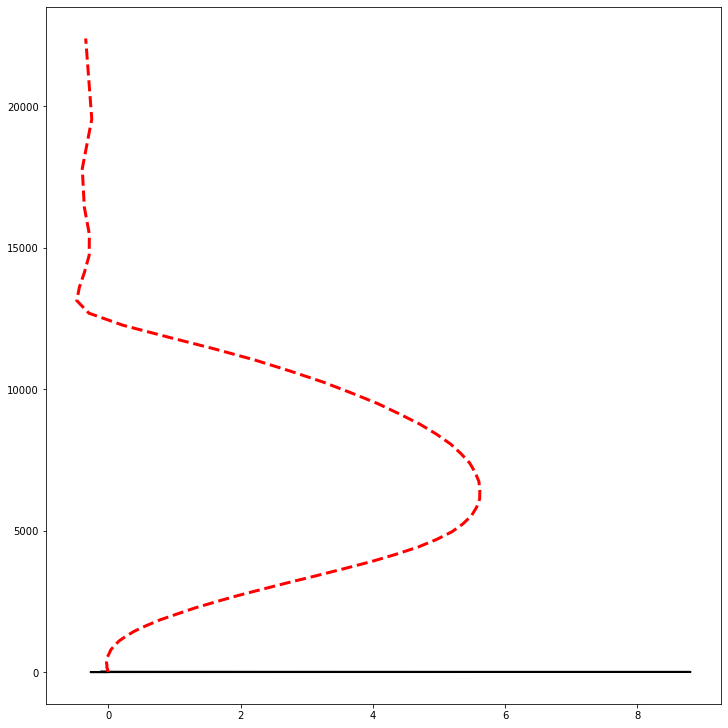

In [34]:
fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))

ax.plot(wprofile_q14.mean(axis=1), zh_q14, color='k', linewidth=2.)

# ax.plot(wprofile_q11.mean(axis=1), zh_q14, color='y')
# ax.plot(wprofile_q12.mean(axis=1), zh_q14, color='orange')
# ax.plot(wprofile_q13.mean(axis=1), zh_q14, color='g')
# ax.plot(wprofile_q15.mean(axis=1), zh_q14, color='b')
# ax.plot(wprofile_q16.mean(axis=1), zh_q14, color='cyan')

ax.plot(fv3_wprofile.mean(axis=1), z, color='r', linewidth=3., linestyle='--' )


In [35]:
wprofile_q14.shape

(60, 1928)

In [36]:
wprofile_q14.mean(axis=1)


array([-1.0803895e-02, -3.8424946e-02, -7.4705131e-02, -1.1596338e-01,
       -1.5977922e-01, -2.0171957e-01, -2.3719263e-01, -2.6152107e-01,
       -2.6982072e-01, -2.5680166e-01, -2.1650884e-01, -1.4199761e-01,
       -2.4440054e-02,  1.4511864e-01,  3.7483397e-01,  6.7023015e-01,
        1.0290592e+00,  1.4440523e+00,  1.9083545e+00,  2.4145184e+00,
        2.9537125e+00,  3.5163887e+00,  4.0919819e+00,  4.6689587e+00,
        5.2357292e+00,  5.7820168e+00,  6.3000884e+00,  6.7848172e+00,
        7.2320070e+00,  7.6359186e+00,  7.9894252e+00,  8.2875500e+00,
        8.5268040e+00,  8.6999340e+00,  8.7959108e+00,  8.8062477e+00,
        8.7277145e+00,  8.5568094e+00,  8.2887783e+00,  7.9205241e+00,
        7.4481936e+00,  6.8617873e+00,  6.1542950e+00,  5.3347478e+00,
        4.4237418e+00,  3.4575584e+00,  2.4941614e+00,  1.5905316e+00,
        8.1469905e-01,  2.5287649e-01, -4.5788281e-02, -1.1876734e-01,
       -7.6980330e-02, -2.7030239e-02, -1.2946480e-02, -1.7873276e-02,
      

In [171]:
iloc = [3,7]
jloc = [4,9]
a[:,iloc,jloc]

array([[0.90689892, 0.86154198],
       [0.95264367, 0.05970853],
       [0.26317061, 0.7963547 ],
       [0.08793383, 0.94187676],
       [0.1990708 , 0.86127705],
       [0.35652919, 0.66656528],
       [0.78279958, 0.21971614],
       [0.93370023, 0.5203817 ],
       [0.24092364, 0.07824167],
       [0.07877182, 0.97936054]])